# Sina Weibo prediction

In [1]:
import gc
import torch
#import cuml
import umap
from jieba import analyse as jbanalyse
import numpy as np
import pandas as pd
import seaborn as sns
import functools as fn
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer
from numpy.typing import ArrayLike
from sklearn.base import BaseEstimator
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
from torch import nn
from tqdm.notebook import tqdm

RANDOM_STATE=8402
RNG=np.random.default_rng(seed=RANDOM_STATE)
CV_SPLITS=5
BATCH_SIZE=(256+64)*2 # for 2 gpu approx 12GB mem-usage each

def gpu_or_else(gpu, no_gpu):
    return gpu if torch.cuda.is_available() else no_gpu
print(gpu_or_else('GPU available', 'no GPU available using CPU'))

2024-04-26 09:38:34.220685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 09:38:34.220784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 09:38:34.345750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU available


Defining the loss function

In [2]:
def mixed_loss(y_true: ArrayLike, y_pred: ArrayLike, bias=[5,3,3], scaling=[.5,.25,.25], thresold=.8):
    precision = 1 - np.sum((np.abs(y_pred-y_true)/(y_true + bias)) * scaling, axis=1)
    sgn_precision = precision > thresold
    count_row_sum = np.sum(np.clip(y_true, a_min=None, a_max=100), axis=1) + 1
    return np.sum(count_row_sum * sgn_precision) / np.sum(count_row_sum)

mixed_scorer = make_scorer(mixed_loss, greater_is_better=True)

## Dataset preperation

In [3]:
def file_to_df(filename, col_names=['uid', 'mid', 'ts', 'forward_n', 'comment_n', 'like_n', 'content']):
    """Helper to parse data. Contains hardcoded logic"""
    df = pd.read_csv(filename, sep='\t', names=col_names)
    if 'ts' in col_names:
        df['ts'] = pd.to_datetime(df['ts'])
    return df

In [4]:
Xy_tv = file_to_df('/kaggle/input/sna-weibo-data/Weibo Data/weibo_train_data(new)/weibo_train_data.txt')
X_tv = Xy_tv.drop(['forward_n', 'comment_n', 'like_n'], axis=1)
y_tv = Xy_tv[['forward_n', 'comment_n', 'like_n']].replace([np.inf, -np.inf], np.nan)

## Data analysis

### Navive analysis

In [5]:
def embedd(
    data,
    vectorizer=TfidfVectorizer(stop_words='english', max_features=512),
    reducer=gpu_or_else(
        umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=2),# TODO maybe enable GPU: cuml.UMAP(n_neighbors=10, min_dist=0.3, n_components=2),
        umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=2),
    )
):
    embeddings = vectorizer.fit_transform(data)
    return reducer.fit_transform(embeddings)

def plot_embeddings(embeddings, y):
    categories = np.sum(y * [.5, .25, .25], axis=1)
    alhpa_vals = np.log10(categories / categories.max() + 0.01) / np.log10(1.01)
    scaled_alpha_vals = np.clip((alhpa_vals - alhpa_vals.min()) / (alhpa_vals.max() - alhpa_vals.min()), a_min=None, a_max=1)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        c=categories,
        cmap='Spectral',
        s=5,
        alpha=scaled_alpha_vals
    )
    plt.colorbar(scatter)
    plt.title('Projection of Text Embeddings', fontsize=18)
    plt.xlabel('dim 1', fontsize=14)
    plt.ylabel('dim 2', fontsize=14)
    plt.grid(True)
    plt.show()

### Naive Embeddings

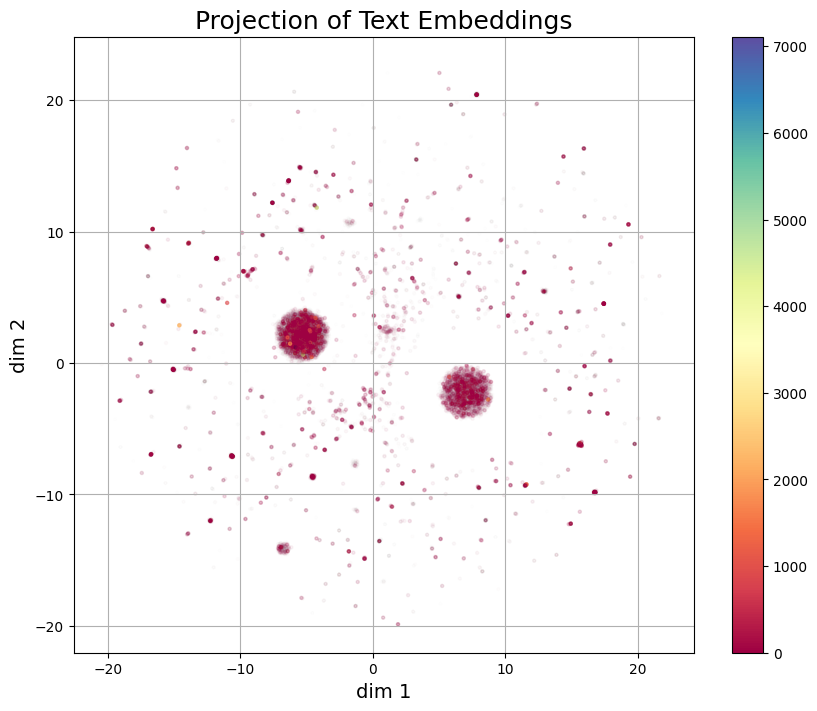

In [6]:
plot_embeddings(
    embedd(X_tv.content.sample(100_000, random_state=RANDOM_STATE)),
    y_tv.sample(100_000, random_state=RANDOM_STATE)
)

### Jieba embeddings

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.165 seconds.
Prefix dict has been built successfully.
/opt/conda/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/conda/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


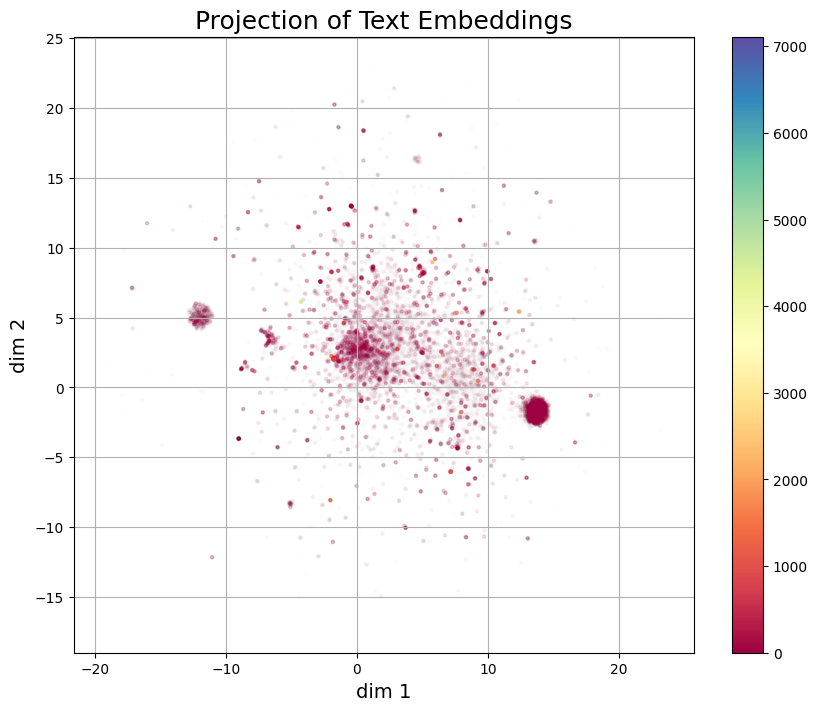

In [7]:
plot_embeddings(
    embedd(
        X_tv.content.sample(100_000, random_state=RANDOM_STATE),
        vectorizer=TfidfVectorizer(analyzer=fn.partial(jbanalyse.extract_tags), max_features=512),
    ),
    y_tv.sample(100_000, random_state=RANDOM_STATE),
)

### Huggingface embeddings

In [8]:
class TextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: val[idx].clone().detach() for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

class ChineseBertVectorizer():
    def __init__(
        self,
        device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
        batch_size=1024,
        verbose=0
    ):
        self.tokenizer = AutoTokenizer.from_pretrained(
            "google-bert/bert-base-chinese", 
            padding=True,
            truncation=True
        )
        self.model = AutoModel.from_pretrained("google-bert/bert-base-chinese")
        self.device = device
        self.batch_size=batch_size
        self.verbose=verbose
    
    def fit_transform(self, data, batch_size=None, verbose=None):
        if not isinstance(data, list):
            data = data.tolist()
        if not batch_size:
            batch_size = self.batch_size
        if not verbose:
            verbose = self.verbose
        
        try:
            return self.get_embeddings(data, batch_size=batch_size, verbose=verbose)
        finally:
            if verbose:
                print('cleaning up...')
            if verbose > 1:
                print(torch.cuda.memory_summary())
            gc.collect()
            torch.cuda.empty_cache()
            if verbose:
                print('done cleaning')
            if verbose > 1:
                print(torch.cuda.memory_summary())


    def get_embeddings(self, data, batch_size, verbose=0):
        if verbose:
            print('tokenizing...')
        encoded_input = self.tokenizer(
            data, padding=True, truncation=True, return_tensors='pt'
        )
        dataset = TextDataset(encoded_input)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        embeddings = []
        embedder = nn.DataParallel(self.model)
        embedder = embedder.to(self.device)
        for batch in tqdm(loader, disable=verbose<1, desc='embedding', unit='batch'):
            batch_ = {k: v.to(self.device) for k, v in batch.items()}
            with torch.no_grad():
                if verbose>1:
                    print(torch.cuda.memory_summary())
                    
                outputs = embedder(**batch_)
                if self.device.type == 'cuda':
                    batch_embeddings = outputs.last_hidden_state[:, 0, :]
                    embeddings.append(batch_embeddings.cpu())
                    for v in batch_.values():
                             del v
                    del batch_
                    del outputs
                    gc.collect()
                    torch.cuda.empty_cache()
                else:
                    batch_embeddings = outputs.last_hidden_state[:, 0, :]
                    embeddings.append(batch_embeddings.cpu())
        
        if self.device.type == 'cuda':
            del embedder
            gc.collect()
            torch.cuda.empty_cache()

        embeddings = torch.cat(embeddings, dim=0)
        if verbose:
            print('embeddings done')

        return embeddings

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizing...


embedding:   0%|          | 0/157 [00:00<?, ?batch/s]

embeddings done
cleaning up...
done cleaning


/opt/conda/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


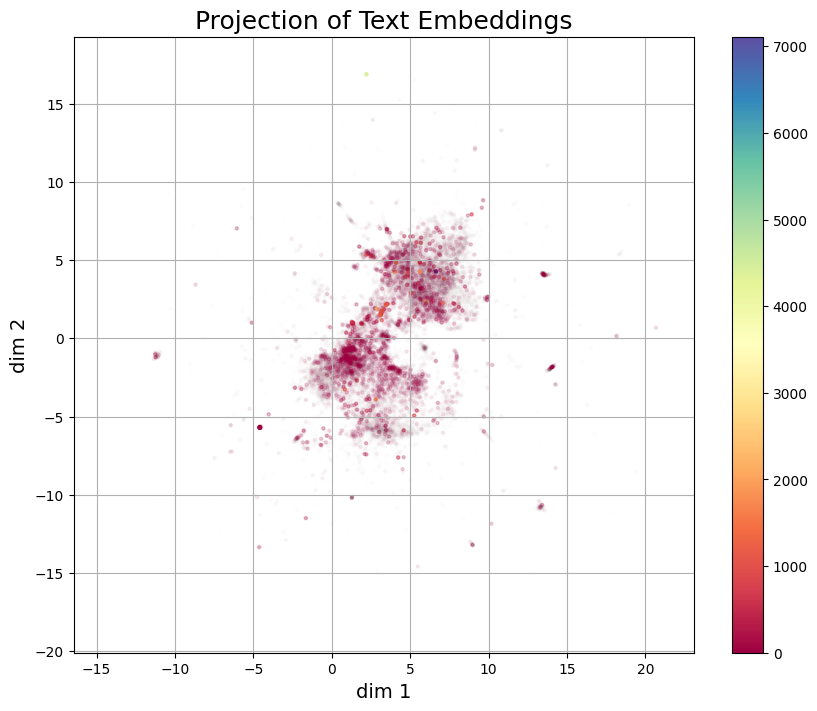

In [9]:
plot_embeddings(
    embedd(
        X_tv.content.sample(100_000, random_state=RANDOM_STATE),
        vectorizer=ChineseBertVectorizer(batch_size=BATCH_SIZE, verbose=1)
    ),
    y_tv.sample(100_000, random_state=RANDOM_STATE)
)

### Target analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


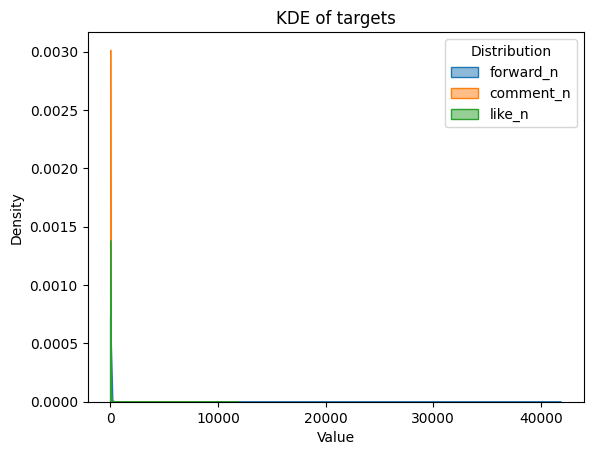

In [10]:
for column in y_tv.columns:
    sns.kdeplot(y_tv[column], label=column, fill=True, common_norm=False, alpha=0.5)

plt.title('KDE of targets')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(title='Distribution')

Let's log scale it to make it more gaussian

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

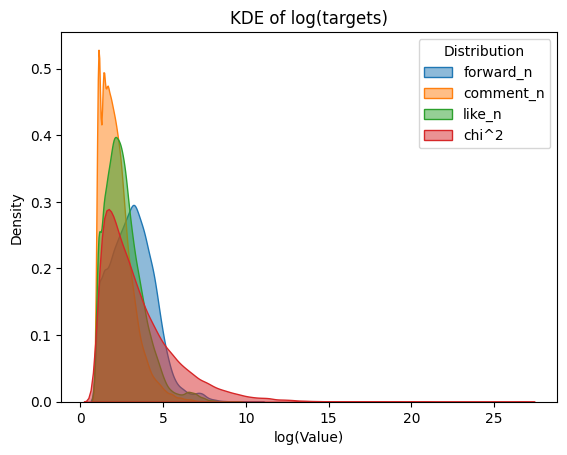

In [11]:
y_tv_no_low = y_tv[np.all(y_tv > 2, axis=1)]
for column in y_tv.columns:
    sns.kdeplot(np.log(y_tv_no_low[column]), label=column, fill=True, common_norm=False, alpha=0.5)
    
sns.kdeplot(RNG.chisquare(2.5,size=y_tv_no_low.shape[0])+1, label='chi^2', fill=True, common_norm=False, alpha=0.5)

plt.title('KDE of log(targets)')
plt.xlabel('log(Value)')
plt.ylabel('Density')
plt.legend(title='Distribution')

## Model definition

In [12]:
models: list[tuple[str,BaseEstimator]] = [
    ('base-0', DummyRegressor(strategy='constant', constant=[0,0,0]))
]

## Eval

In [13]:
ts_cv = TimeSeriesSplit(n_splits=CV_SPLITS)

In [14]:
scores = {n: cross_val_score(
    m,
    X_tv.sample(100_000, random_state=RANDOM_STATE),
    y_tv.sample(100_000, random_state=RANDOM_STATE),
    cv=ts_cv,
    scoring=mixed_scorer
) for n, m in models}

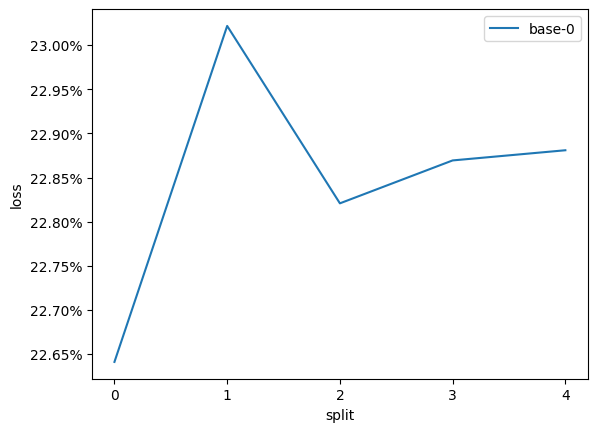

In [15]:
ax = pd.DataFrame(scores).plot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=2))
ax.set_xticks(np.arange(CV_SPLITS))
ax.set_ylabel('loss')
_ = ax.set_xlabel('split')